# Reuters 'Crude' Article Analysis

- Based on code and procedure from the Stanford NLP Deep Learning
    - found in DS_Recipes/NLP/Stanford Class
    - this file will exclude the instruction and sample code found in the tutorial and only focus on the analysis of the Reuters data set

## Word Vectors

- Word vectors and word embeddings are used interchangeably
    - specify a word's meaning by changing from high one-dimensional space to a continuous vector that is a much lower dimension
        - This is like taking the word 'run' and encoding as a vector of continuous numbers such as:
            [1.002, -2.033, -9.881, 13.032, ..., 2.818] 
            
- Word vectors center around idea that similar words have similar context, and thus will be relatively proximal to a shared subset of words

## In this script:
- Two main types of word vectors / word embeddings used in this script:
    - Count-based word vectors: co-occurrence matrix
    - Prediction-based word vectors: word2vec

# Packages and Global Variables
- this may not be all inclusive as more may be more approriately run at beginning

In [1]:

import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 5

import pprint

from gensim.models import KeyedVectors
from gensim.test.utils import datapath

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
## download preloaded dataset (10,788 documents, 1.3 mil words)
## https://www.nltk.org/book/ch02.html
## uncomment download line below if not already downloaded
# nltk.download('reuters') 
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp

## Used for dimension reduction on co-occurrence matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

## Generate global variablesabs
## Start and End tokens will be applied to beginning
##   and end of each document
START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

# Read Corpus
- Reuters corpus contain 90 categories that are split into train and test
- for this project, the Reuters corpus will be subset to only include the "Crude" category which includes articles about oil, gas, etc
- https://www.nltk.org/book/ch02.html

In [2]:
'''
Parameters:
    category is a string referring to the Reuters category type
Return: 
    a list of lists: a list of the words from each file
'''


def read_corpus(category='crude'):
    files = reuters.fileids(category)
    return[[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [3]:
# Review article in the Reuters corpus selected for crude category

# Remove and run to test-----------
#my_corpus = read_corpus()
#pprint.pprint(my_corpus[:1], compact=True, width=100)

# Obtain Distinct Words
- try to avoid for loops since they are slower
- instead use set comprehensions

In [4]:
'''
Parameters:
    corpus: list of list from read file defined above
Return:
    corpus_words: list of string, distinct words across corpus, sorted
    num_corpus_words: number of distinct words across corpus
'''

def distinct_words(corpus):
    corpus_words_dist = sorted(list(set([word for doc in corpus for word in doc])))
    corpus_words_dist_cnt = len(corpus_words_dist)
    return corpus_words_dist, corpus_words_dist_cnt

In [5]:
# Test run distinct_words function
#    print last 50 unique words and the number of unique words in corpus

# Remove and run to test-----------
#corpus_words_dist, corpus_words_dist_cnt = distinct_words(my_corpus)
#print(corpus_words_dist[-50:])
#print(corpus_words_dist_cnt)


# Vector Analysis Methods

## Count-Based Word Vector: Co-occurrence matrix

- count of how often words co-occur with each other in a document based on a specified window
    - a window of size $n$ means $n$ preceeding words and $n$ subsequent words in the document where $w_i$ is the word of interest
        - $w_{i-n} \dots w_{i-1}$, $w_i$, $w_{i+1} \dots w_{i+n}$
        
        - iterating over the document in word by word fashion, each word becomes $w_i$ and the number of times $w_i$ occurs with other words in the window $n$ are counted and entered in a symetric matrix

In [22]:
""" Compute co-occurrence matrix for the given corpus and window_size (default of 4).

    Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
          number of co-occurring words.

          For example, if we take the document "START All that glitters is not gold END" with window size of 4,
          "All" will co-occur with "START", "that", "glitters", "is", and "not".

    Params:
        corpus (list of list of strings): corpus of documents
        window_size (int): size of context window
    Return:
        M (numpy matrix of shape (number of corpus words, number of corpus words)): 
            Co-occurence matrix of word counts. 
            The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
        word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
"""

def compute_co_occurrence_matrix(corpus, window_size):

    
    # call the distinct words function to use unique words
    corpus_words_dist, corpus_words_dist_cnt = distinct_words(corpus)
    
    M = None       # set to none at start of function
    word2Idx = {}  # set to blank at start of function

    # Create a matrix based on size of corpus after runing distinct_words function
    M = np.zeros((corpus_words_dist_cnt, corpus_words_dist_cnt))  # create n by n matrix
    
    # Creates an word:index dictionary of entire unique word corpus
    word2Ind = dict(zip(corpus_words_dist, range(corpus_words_dist_cnt)))

    # Loop through each document (list of words) in corpus
    for doc in corpus:
        
        # cur_idx will be the index number of each word within that document
        # -used to sysematically go through each word (0 to len(doc)) and find words
        # -that are window_size positions before and after that word
        cur_idx = 0         # resets at 0 at start of each document
        doc_len = len(doc)  # word count of each document
        
        ## while index is between zero and document length
        while cur_idx < doc_len:
            # far left and far right index numbers (based on cur_idx & window_size)
            l_bound = max(cur_idx - window_size, 0)   # max excludes negative indices
            r_bound = min(cur_idx + window_size + 1, doc_len)   # min stops at doc_len
            
            # all words for this iterations window index numbers (l_bound to r_bound)
            window_words = doc[l_bound:cur_idx] + doc[(cur_idx + 1):r_bound]
            
            # get the word associated with the cur_idx
            center_word = doc[cur_idx]
            
            # using that center_word, get it's index number within the entire corpus
            #center_idx = word2Idx[center_word]

            # Now that we have all the words in a specific window, count the number
            # of times each word in the word window appears near the center word in
            # the full corpus (within the window size)
            for window_word in window_words:
                # get full corpus dict index for the window word
                window_idx = word2Ind[window_word]
                # add 1 in matrix M for each window match
                M[window_idx, word2Ind[center_word]] += 1
                
            cur_idx += 1
            
    return M, word2Ind

### Reduce Matrix Dimensionality

- The resulting matrix from compute_co_occurrence_matrix is a large sparse matrix of shape:
    - distinct words rows x distinct words columns
- Singular Value Decomposition (SVD) is a generalized PCA to select top k principal components thus reducing the dimensionality and improving processing time while keeping semantic relationships between words
    - SVD is computationally expensive so trucated SVD can provide k vector components if k is expected to be small
        - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
        - All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but
        - Only scipy and sklearn provide an implementation of Truncated SVD, and 
        - Only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD
        
    
    

In [31]:
""" 
Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
    to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
        - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

    Params:
        M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
        k (int): embedding size of each word after dimension reduction
    Return:
        M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                In terms of the SVD from math class, this actually returns U * S
"""


def reduce_to_k_dim(M, k):

    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    seed = 3232  # set seed
    # create new blank M_reduced (reset each time function is run)
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    tsvd = TruncatedSVD(n_components=k,
                        n_iter=n_iters,
                        random_state=seed)
    M_reduced = tsvd.fit_transform(M)

    print("Done.")
    return M_reduced

### Plot M_reduced Word Embeddings

- 2D vectors plotted using Matplotlib

In [32]:
""" Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
"""

def plot_embeddings(M_reduced, word2Ind, words):
    x_coords = M_reduced[:, 0]
    y_coords = M_reduced[:, 1]
    
    for word in words:
        idx = word2Ind[word]
        M_reduced_word = M_reduced[idx]
        x = M_reduced_word[0]
        y = M_reduced_word[1]
        
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=8)
        

### Combine Functions with Co-occurrence Matrix

Running Truncated SVD over 8185 words...
Done.


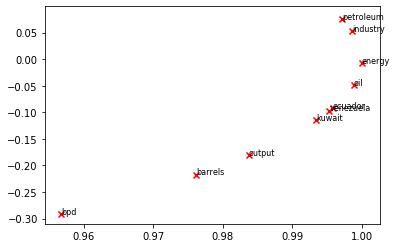

In [34]:

reuters_corpus = read_corpus()
my_corpus = reuters_corpus

M_co_occurrence, word2Ind_co_occrrence = compute_co_occurrence_matrix(my_corpus, window_size = 4)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k = 2)

# Rescale rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis = 1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # uses numpy array broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry',
         'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occrrence, words)

In [ ]:
# Note the output above: some clusters seem to align while others are where we would expect them

## Prediction-based word vectors: word2vec
- using Word2Vec skip-gram model
    - develop vector representation of a center word such that it predicts nearby words
    - see paper: https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

In [41]:
def load_word2vec():
    
    import gensim.downloader as api
    
    wv_from_bin = api.load('word2vec-google-news-300')
    vocab = list(wv_from_bin.vocab.keys())
    
    print('Loaded vocab size %i' % len(vocab))
    return wv_from_bin

In [ ]:
wv_from_bin = load_word2vec()

[===-----------------------------------------------] 6.7% 110.9/1662.8MB downloaded